## Import

#### import 1

In [1]:
import os
import cv2
import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

#### import 2

In [2]:
%env SM_FRAMEWORK=tf.keras

# 패키지 불러오기
import os
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import numpy as np 
import pandas as pd
import random

from sklearn.model_selection import train_test_split

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as keras

from glob import glob

from segmentation_models import Unet
from segmentation_models.metrics import iou_score

from scipy import ndimage
from tqdm.notebook import tqdm

import cv2
import cv2 as cv2
import multiprocessing
import os

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


#### Gpu

In [3]:
import tensorflow as tf

print(tf.__version__)

2.10.0


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 13)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16034271016335211611
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 13958643712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10954108956229700946
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:07:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Hyper parameter & Data Set

In [7]:
# 하이퍼 파라미터
image_height = 256
image_width = 256

batch_size = 16
epoch = 20

backbone = 'resnet101'
threshold = '(0~5]'

LR = 1e-4
optim = tf.keras.optimizers.Adam(LR)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 경로 설정
train_image_dir = f'./train/img{threshold}/'
train_mask_dir = f'./train/mask{threshold}/'

valid_image_dir = f'./valid/img/'
valid_mask_dir = f'./valid/mask/'

# 이미지 데이터 생성을 위한 ImageDataGenerator 설정
image_datagen = ImageDataGenerator(rescale=1./255)  # 이미지를 0-1 범위로 정규화

In [ ]:
# 원본 이미지 및 마스킹 이미지 불러오기
train_image_generator = image_datagen.flow_from_directory(
    train_image_dir,
    target_size=(image_height, image_width),
    class_mode=None,
    batch_size = batch_size,
    seed=42
)

train_mask_generator = image_datagen.flow_from_directory(
    train_mask_dir,
    target_size=(image_height, image_width),
    class_mode=None,
    batch_size = batch_size,
    seed=42,
)

valid_image_generator = image_datagen.flow_from_directory(
    valid_image_dir,
    target_size=(image_height, image_width),
    class_mode=None,
    batch_size = batch_size,
    shuffle=False,
    seed=42
)

valid_mask_generator = image_datagen.flow_from_directory(
    valid_mask_dir,
    target_size=(image_height, image_width),
    class_mode=None,
    batch_size = batch_size,
    shuffle=False,
    seed=42,
)

In [10]:
# 학습 데이터 생성기
train_generator = zip(train_image_generator, train_mask_generator)

# 검증 데이터 생성기
valid_generator = zip(valid_image_generator, valid_mask_generator)


In [11]:
import math

train_step = math.ceil(train_image_generator.n / batch_size)
valid_step = math.ceil(valid_image_generator.n / batch_size)

## Model Training (train, valid)

In [12]:
import segmentation_models as sm

from segmentation_models import PSPNet
from segmentation_models import FPN
from segmentation_models import Linknet
from segmentation_models import Unet

In [13]:
base_model = Unet(backbone_name=backbone, 
                  encoder_weights='imagenet', 
                  encoder_freeze=True, 
                  activation="sigmoid", 
                  classes = 1)
model = base_model

In [14]:
# optimizer
LR = 1e-4
optim = tf.keras.optimizers.Adam(LR)

# loss
dice_loss = sm.losses.DiceLoss()
# Jaccard_loss = sm.losses.JaccardLoss()
total_loss = dice_loss # + Jaccard_loss

total_metrics=[sm.metrics.iou_score, sm.metrics.f1_score]

In [15]:
# 모델 컴파일
model.compile(optimizer=optim, loss=total_loss, metrics=total_metrics)

In [16]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(f'./model/{backbone}.h5', 
                                       save_weights_only=True, 
                                       save_best_only=True, 
                                       monitor='val_iou_score', 
                                       mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(),
]

In [17]:
# Model Fitting
hist = model.fit(train_generator,
                 steps_per_epoch = train_step,
                 epochs = epoch,
                 callbacks=callbacks,
                 validation_data = valid_generator,
                 validation_steps = valid_step)

Epoch 1/20


846/846 [==============================] - 148s 163ms/step - loss: 0.5048 - iou_score: 0.3964 - f1-score: 0.5591 - val_loss: 0.6478 - val_iou_score: 0.3076 - val_f1-score: 0.4285 - lr: 1.0000e-04
Epoch 2/20
846/846 [==============================] - 136s 161ms/step - loss: 0.3648 - iou_score: 0.5360 - f1-score: 0.6969 - val_loss: 0.4538 - val_iou_score: 0.4710 - val_f1-score: 0.5955 - lr: 1.0000e-04
Epoch 3/20
846/846 [==============================] - 136s 161ms/step - loss: 0.3290 - iou_score: 0.5750 - f1-score: 0.7292 - val_loss: 0.4552 - val_iou_score: 0.4937 - val_f1-score: 0.6146 - lr: 1.0000e-04
Epoch 4/20
846/846 [==============================] - 136s 161ms/step - loss: 0.3071 - iou_score: 0.5994 - f1-score: 0.7487 - val_loss: 0.4219 - val_iou_score: 0.5117 - val_f1-score: 0.6310 - lr: 1.0000e-04
Epoch 5/20
846/846 [==============================] - 136s 161ms/step - loss: 0.2915 - iou_score: 0.6169 - f1-score: 0.7622 - val_loss: 0.4162 - val_iou_score: 0.5225 - val_f1-score: 

In [ ]:
model.save('./model/final_{backbone}.h5')

In [18]:
loss, iou_score, f1_score, val_loss, val_iou_score, val_f1_score, lr = hist.history.values()

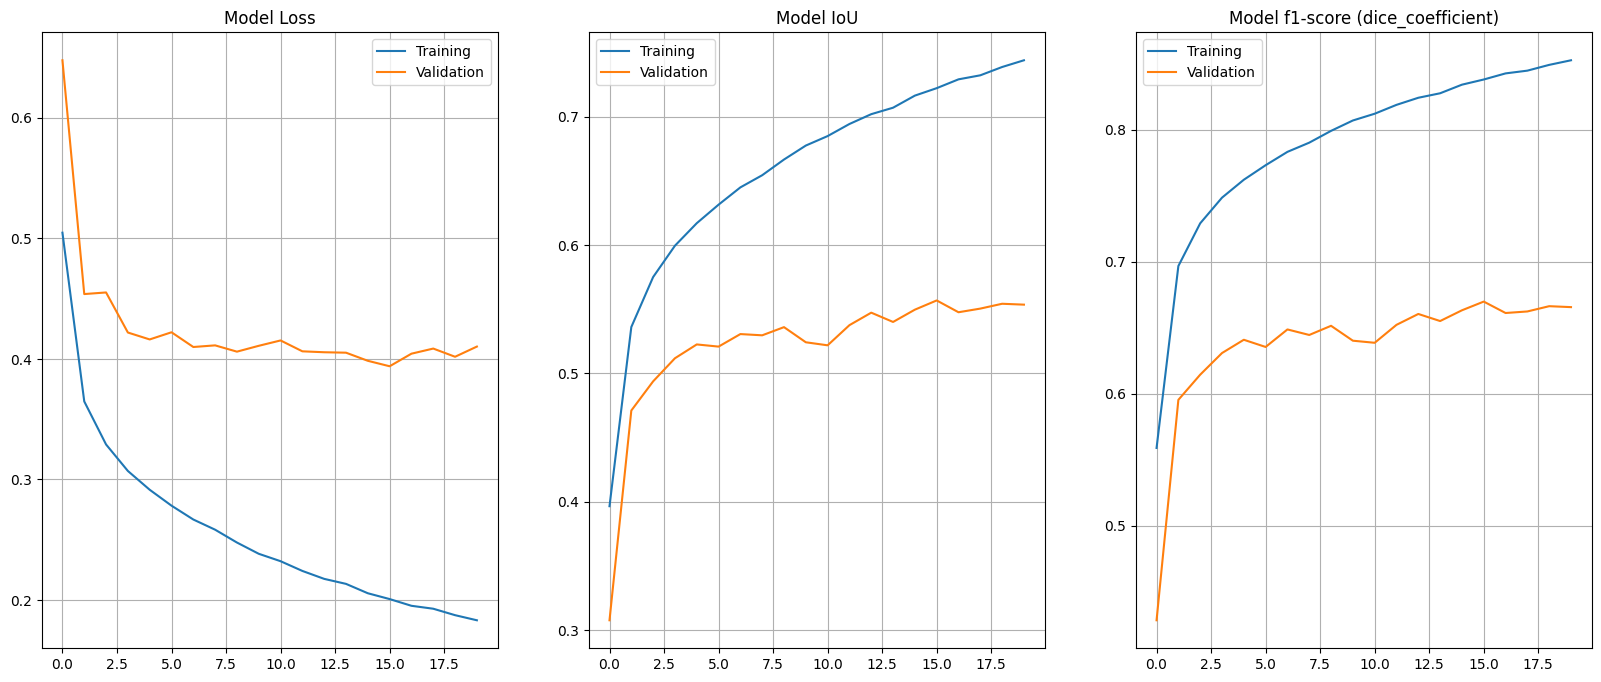

In [19]:
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validation")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model IoU")
plt.plot(iou_score, label="Training")
plt.plot(val_iou_score, label="Validation")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model f1-score (dice_coefficient)")
plt.plot(f1_score, label="Training")
plt.plot(val_f1_score, label="Validation")
plt.legend()
plt.grid()

plt.show()

## Model Evaluation

In [16]:
from tensorflow.keras.models import load_model

# 모델 불러오기
model = load_model('./model/final_{backbone}.h5', custom_objects={'dice_loss': dice_loss, 'iou_score': sm.metrics.iou_score})

In [ ]:
final_image_generator = image_datagen.flow_from_directory(
    valid_image_dir,
    target_size=(image_height, image_width),
    class_mode=None,
    batch_size = 1,
    shuffle=False,
    seed=42
)

final_mask_generator = image_datagen.flow_from_directory(
    valid_mask_dir,
    target_size=(image_height, image_width),
    class_mode=None,
    batch_size = 1,
    shuffle=False,
    seed=42,
)

In [ ]:
# 검증 데이터 생성기
final_generator = zip(final_image_generator, final_mask_generator)
final_step = math.ceil(final_image_generator.n / batch_size)

In [ ]:
scores = model.evaluate(final_generator, steps=final_step)

output_dir = f"./results/"
os.makedirs(output_dir, exist_ok=True)

output_file = os.path.join(output_dir, f"{backbone}_evaluation_results.txt")
with open(output_file, "w") as f:
    f.write("Loss: {:.5}\n".format(scores[0]))
    for metric, value in zip(total_metrics, scores[1:]):
        f.write("final Data mean {}: {:.5}\n".format(metric.__name__, value))

print("Evaluation results saved to:", output_file)